In [0]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder

(x_train, y_train), (x_test, y_test) = mnist.load_data()
target_enc = OneHotEncoder().fit(y_train.reshape(-1,1))
y_train = target_enc.transform(y_train.reshape(-1,1)).todense()
y_test = target_enc.transform(y_test.reshape(-1,1)).todense()
x_train, x_test = x_train / 255.0, x_test / 255.0

h, w = 28, 28
num_classes = 10
noise_mean, noise_stddev = 0.0, 0.3

def collapse(batch):
  return np.reshape(batch, (batch.shape[0], -1))

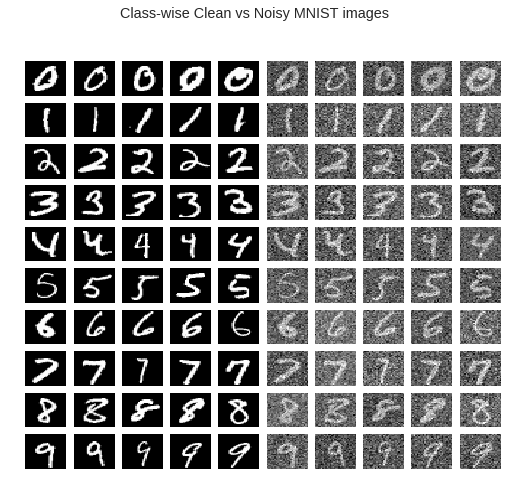

In [2]:
num_sample_per_class = 5
num_row, num_col = 10, num_sample_per_class*2
f,subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

Xnoisy = x_train + np.random.normal(noise_mean,noise_stddev,(x_train.shape[0],h,w))

for digit in range(num_classes):
      digit_idxs = np.argmax(y_train,axis=1) == digit
      digit_idxs = np.arange(0,x_train.shape[0]).reshape((-1,1))[digit_idxs]
      digit_idxs = np.random.choice(digit_idxs, num_sample_per_class)
      
      for num_sample, sample in enumerate(digit_idxs):
          subplots[digit,num_sample].imshow(x_train[sample], cmap='gray', aspect='auto')
          subplots[digit,num_sample].grid(b=False)
          subplots[digit,num_sample].axis('off')
          
      for num_sample, sample in enumerate(digit_idxs):
          num_sample = num_sample + len(digit_idxs)
          subplots[digit,num_sample].imshow(Xnoisy[sample], cmap='gray', aspect='auto')
          subplots[digit,num_sample].grid(b=False)
          subplots[digit,num_sample].axis('off')

f.suptitle("Class-wise Clean vs Noisy MNIST images")
f.set_size_inches(8.5, 7.5, forward=True)

In [0]:
class DeepDenoisingAutoencoder:
  
  def __init__(self, x, is_training, layers=[512, 384, 256], 
               noise_mean=0.0, noise_stddev=0.3, act=tf.nn.leaky_relu):
    
    self.x, self.is_training = x, is_training
    self.noise_mean, self.noise_stddev  = noise_mean, noise_stddev
    self.act = act
    self.layers = layers
    
    self.noisy_x, self.bottleneck, self.output = None, None, None
    self.loss, self.train_step = None, None
  
  def block(self, h, units, act=None):
    h_next = tf.layers.dense(h, units=units, activation=None)
    h_next = tf.layers.batch_normalization(h_next, training=self.is_training)
    if act is not None:
      h_next = self.act(h_next)
    return h_next
  
  def noisy(self):
    if self.noisy_x is None:
      self.noisy_x = self.x + tf.random_normal(tf.shape(self.x), mean=self.noise_mean, stddev=self.noise_stddev)
    return self.noisy_x
  
  def encoder(self, inp):
    h = inp
    for units in self.layers:
      h = self.block(h, units, act=self.act)
    return h
        
  def decoder(self, inp):
    h = inp
    for units in self.layers[::-1][1:]:
      h = self.block(h, units, act=self.act)
    h = self.block(h, self.x.shape[1], act=tf.nn.relu)
    return h
    
  def inference(self):
    noisy_x = self.noisy()
    input_to_net = tf.cond(is_training, lambda: noisy_x, lambda: self.x)
    self.bottleneck = self.encoder(input_to_net)
    self.output = self.decoder(self.bottleneck)
    return self.output
  
  def get_bottleneck(self):
    return self.bottleneck
    
  def get_loss(self):
    if self.loss is None:
      self.loss = tf.reduce_mean(tf.reduce_sum(tf.square(self.x-self.output)))
    return self.loss
  
  def get_train_step(self):
    if self.train_step is None:
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      with tf.control_dependencies(update_ops):
        self.train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.get_loss())
    return self.train_step
  
  def compute_hiddens(self, sess, X_data, batch_size=512):
    len_X = X_data.shape[0]
    num_forwards, rest = len_X // batch_size, len_X % batch_size
    hiddens = []
    
    def run(x_batch):
      return sess.run(self.get_bottleneck(), feed_dict={self.x: collapse(x_batch), self.is_training:False})
    
    for j in range(num_forwards):
      hiddens.append(run(X_data[j*batch_size:(j+1)*batch_size]))
    
    if rest > 0:
      hiddens.append(run(X_data[batch_size*num_forwards:len_X]))
      
    return np.concatenate(hiddens, axis=0)

# Define model output
x = tf.placeholder(dtype=tf.float32, shape=[None, 784]) 
is_training = tf.placeholder(dtype=tf.bool)

In [4]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

with tf.Session() as sess:
     
  dae = DeepDenoisingAutoencoder(x, is_training, noise_mean=noise_mean, 
                                 noise_stddev=noise_stddev)

  output = dae.inference()
  loss = dae.get_loss()
  train_step = dae.get_train_step()

  init_op = tf.global_variables_initializer()

  # Initialize all variables
  sess.run(init_op)

  # Training parameters
  training_epochs = 5
  batch_size      = 128

  # Number of batches to process to see whole dataset
  batches_each_epoch = x_train.shape[0] // batch_size

  for epoch in range(training_epochs):

    val_loss = sess.run(loss, feed_dict={is_training:True, x: collapse(x_test)})
    print('Epoch: {:06d} - Test Loss : {:.03f}'.format(epoch, val_loss))

    x_train_rec, x_train_noisy = [], []
    for i in range(batches_each_epoch):

      x_batch = x_train[i*batch_size:(i+1)*batch_size]
      sess.run(train_step, feed_dict={is_training:True, x: collapse(x_batch)})
      
      rec, noisy_x = sess.run([output, dae.noisy(), ], feed_dict={x: collapse(x_batch), is_training:True})
      x_train_rec.append(rec)
      x_train_noisy.append(noisy_x)

    x_train_rec = np.concatenate(x_train_rec, axis=0)
    x_train_noisy = np.concatenate(x_train_noisy, axis=0)

    x_train_features = dae.compute_hiddens(sess, x_train)
    x_test_features = dae.compute_hiddens(sess, x_test)

Epoch: 000000 - Test Loss : 4279278.000
Epoch: 000001 - Test Loss : 352875.906
Epoch: 000002 - Test Loss : 209665.094
Epoch: 000003 - Test Loss : 144245.688
Epoch: 000004 - Test Loss : 111643.422


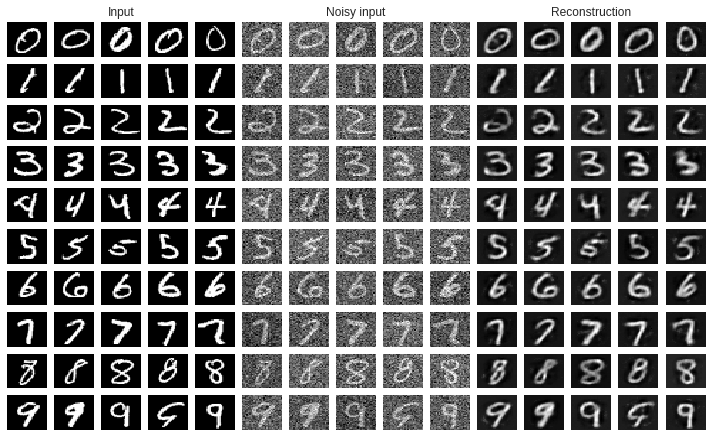

In [5]:
num_sample_per_class = 5

def plot_img(subplot, img):
  subplot.imshow(img, cmap='gray', aspect='auto')
  subplot.grid(b=False)
  subplot.set_xticks([])
  subplot.set_yticks([])
  
f,subplots = plt.subplots(num_classes, num_sample_per_class*3, sharex='col', sharey='row')

for digit in range(num_classes):
      
      digit_idxs = np.argmax(y_train[0:x_train_rec.shape[0]],axis=1) == digit
      digit_idxs = np.arange(0,x_train_rec.shape[0]).reshape((-1,1))[digit_idxs]
      digit_idxs = np.random.choice(digit_idxs, num_sample_per_class)
      
      for num_sample, sample in enumerate(digit_idxs):
          plot_img(subplots[digit, num_sample], x_train[sample])
          plot_img(subplots[digit, num_sample_per_class + num_sample], x_train_noisy[sample].reshape((h,w)))
          plot_img(subplots[digit, 2*num_sample_per_class + num_sample], x_train_rec[sample].reshape((h,w)))

subplots[0, num_sample_per_class//2].set_title("Input")
subplots[0, num_sample_per_class + num_sample_per_class//2].set_title("Noisy input")
subplots[0, 2*num_sample_per_class + num_sample_per_class//2].set_title("Reconstruction")
  
f.set_size_inches(12.5, 7.5, forward=True)

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def evaluation(x_train, y_train, x_test, y_test, num_sample_per_class, n_neighbors=1):
  num_classes = y_train.shape[1]
  balanced_x_train, balanced_y_train = [], []
  
  for digit in range(num_classes):
    digit_idxs = np.argmax(y_train,axis=1) == digit
    digit_idxs = np.arange(0,y_train.shape[0]).reshape((-1,1))[digit_idxs]
    digit_idxs = np.random.choice(digit_idxs, num_sample_per_class)
    balanced_x_train.append(x_train[digit_idxs])
    balanced_y_train.append(y_train[digit_idxs])
  
  balanced_x_train = np.concatenate(balanced_x_train, axis=0)
  balanced_y_train = np.concatenate(balanced_y_train, axis=0)
    
  clf = KNeighborsClassifier(n_neighbors=1)
  clf.fit(balanced_x_train, balanced_y_train)  
  
  return accuracy_score(y_test, clf.predict(x_test))

num_sample_per_class = 100
print("Evaluation with training set size: {}".format(num_sample_per_class*num_classes))
acc_raw = evaluation(collapse(x_train), y_train, collapse(x_test), y_test, num_sample_per_class)
acc_dae = evaluation(x_train_features, y_train, x_test_features, y_test, num_sample_per_class)
print("Test set accuracy from grayscale features {0:.3f}".format(acc_raw))
print("Test set accuracy from DAE features {0:.3f}".format(acc_dae))

Evaluation with training set size: 1000
Test set accuracy from grayscale features 0.884
Test set accuracy from DAE features 0.906


**************************************************
Evaluation with training set size: 200
Test set accuracy from grayscale features 0.806
Test set accuracy from DAE features 0.824
**************************************************
Evaluation with training set size: 400
Test set accuracy from grayscale features 0.831
Test set accuracy from DAE features 0.865
**************************************************
Evaluation with training set size: 600
Test set accuracy from grayscale features 0.857
Test set accuracy from DAE features 0.883
**************************************************
Evaluation with training set size: 800
Test set accuracy from grayscale features 0.876
Test set accuracy from DAE features 0.889
**************************************************
Evaluation with training set size: 1000
Test set accuracy from grayscale features 0.881
Test set accuracy from DAE features 0.905


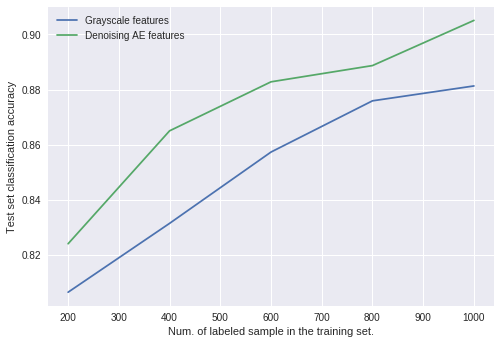

In [7]:
accuracies_raw_features, accuracies_dae_features = [], []

num_sample_list = list(range(20,101,20))
for num_sample_per_class in num_sample_list:
  print("*"*50)
  print("Evaluation with training set size: {}".format(num_sample_per_class*num_classes))
  acc_raw = evaluation(collapse(x_train), y_train, collapse(x_test), y_test, num_sample_per_class)
  acc_dae = evaluation(x_train_features, y_train, x_test_features, y_test, num_sample_per_class)
  print("Test set accuracy from grayscale features {0:.3f}".format(acc_raw))
  print("Test set accuracy from DAE features {0:.3f}".format(acc_dae))
  accuracies_raw_features.append(acc_raw)
  accuracies_dae_features.append(acc_dae)
  
plt.plot(num_classes*np.array(num_sample_list), accuracies_raw_features, label="Grayscale features")
plt.plot(num_classes*np.array(num_sample_list), accuracies_dae_features, label="Denoising AE features")
plt.xlabel("Num. of labeled sample in the training set.")
plt.ylabel("Test set classification accuracy")
plt.legend()
pass